In [6]:
import numpy as np # vectorization and arrays
import pandas as pd # visualization
import random # for randomization
import matplotlib.pyplot as plt # for graphing
import copy # to mutate lists that we want to mutate
import os # to make folder and save files
import streamlit as st # for the GUI

In [2]:
def run_experiment(size = 2):
    """
    Parameters:
    size - an integer to resize the graph if the user
    has a different size screen
    
    Returns:
    The map and the random starting points
    
    Purpose:
    To generate a graph with our different cell typesNorm
    """

    # user can change this value based on the computer screen size (default = 2)
    if int(size) < 0:
        size = 2

    graph_size_x = 100 # pixel size x is double pixel size y
    graph_size_y = 50 # pixel size y is double pixel size x
        
    # size of the figure on the screen
    fig_x = size * (max([graph_size_x,graph_size_y])/min([graph_size_x,graph_size_y])) * 5 # fig x is double fig y
    fig_y = int(fig_x / 2) # fig y is half of fig x
    
    global all_square_coordinates
    # let's see if the all_square_coordinates variable exists
    # if it does we do not intialize it again
    # if it does NOT exist we initialize the variable once to be used throughout
    # every single random graph generation
    try:
        len(all_square_coordinates) # if we can't get the length it doesnt exist
    except: # so let's initialize it
        # generating random x and y coordinates
        x_range = np.arange(0, graph_size_x )
        y_range = np.arange(0, graph_size_y)

        # this double for loop is not O(n^2) it is O(m x n), so it's good - not exponential
        all_square_coordinates = []
        for x_coord in x_range:
            for coordinate_pair in [(x_coord,y) for y in y_range]:
                all_square_coordinates.append(coordinate_pair)
        
    # intializing the fig size (screen size)
    fig_size = (fig_x,fig_y)
    fig = plt.figure()
    fig.set_size_inches(fig_x, fig_y)

    # adding one subplot of our graph (we can add more later)
    ax = fig.add_subplot(1, 1, 1, autoscale_on = False)
    # make the graph 100 x 50 pixels
    ax.scatter([0,100 + 1],[0,50 + 1], color = 'white')
    
    # creating grid lines for x and y
    ax.set_xticks(np.arange(0,graph_size_x + 1))
    ax.set_yticks(np.arange(0,graph_size_y + 1))

    # getting rid of tick labels with an empty list
    ax.set_yticklabels([])
    ax.set_xticklabels([])

    # enabling the grid
    ax.grid()

    # calculating size of square to fit the graph
    square_shade_size = fig_x * fig_y / (graph_size_x / graph_size_y)

    # to ensure that we don't randomly pick a cell we have already chosen
    available_coords = copy.deepcopy(all_square_coordinates)
    
    # shuffle our coords 10 times!
    for _ in range(0,10):
        random.shuffle(available_coords)
    
    
    #############################################################################
    # NORMAL CELLS
    normal_cells = available_coords[0:2500]
    
    # getting x and y pairs
    normal_cells_x = np.array([coord[0] for coord in normal_cells])
    normal_cells_y = np.array([coord[1] for coord in normal_cells])
    
    # shade in cells and color points
    # using broadcasting to apply a -0.5 on all x  y  to center our shaded square on the graph
    normal_cells_ax = ax.scatter(normal_cells_x+.5, normal_cells_y+.5, color = 'orange', s = square_shade_size, marker = ",",
                             label = "Normal Cells")
    #############################################################################
    # HIGHWAY CELLS
    highway_cells = available_coords[2500:3500]

    # getting x and y pairs
    highway_cells_x = np.array([coord[0] for coord in highway_cells])
    highway_cells_y = np.array([coord[1] for coord in highway_cells])
    
    # using broadcasting to apply a -0.5 on all x and y coordinates to center our shaded square on the graph
    highway_cells_ax = ax.scatter(highway_cells_x+.5, highway_cells_y+.5, color = 'red', s = square_shade_size, marker = ",",
                             label = "Highway Cells")
    ##############################################################################
    # HARD TO TRAVERSE CELLS
    hard_cells = available_coords[3500:4500]
        
    # getting x and y pairs
    hard_cells_x = np.array([coord[0] for coord in hard_cells])
    hard_cells_y = np.array([coord[1] for coord in hard_cells])
    
    # shade in cells and color points
    # using broadcasting to apply a -0.5 on all x and y coordinates to center our shaded square on the graph
    hard_cells_ax = ax.scatter(hard_cells_x+.5, hard_cells_y+.5, color = 'pink', s = square_shade_size, marker = ",",
                             label = "Hard To Traverse Cells")
    ##############################################################################
    # CHOOSING A RANDOM START CELL
    # plotting the random starting point
    random_pair = random.choice(available_coords[0:4500])
    random_x_start = random_pair[0]
    random_y_start = random_pair[1]
    ##############################################################################
    
    # BLOCKED CELLS, rest of the available coords are now blocked
    blocked_cells = available_coords[4500:5000]
    
    # getting x and y pairs
    blocked_cells_x = np.array([coord[0] for coord in blocked_cells])
    blocked_cells_y = np.array([coord[1] for coord in blocked_cells])
    
    # shade in cells and color points
    # using broadcasting to apply a -0.5 on all x and y coordinates to center our shaded square on the graph
    blocked_cells_ax = ax.scatter(blocked_cells_x+.5, blocked_cells_y+.5, color = 'gray', s = square_shade_size, marker = ",",
                             label = "Blocked Cells")
    ##############################################################################

    starting_point = ax.scatter(random_x_start+.5,random_y_start+.5, color = 'blue', s = square_shade_size * 4.5, marker = '*',
                                   label = "Start")
    
    # remove the exta ticks (making our graph look pretty)
    plt.tick_params(bottom = False, left = False)

    # darken the grid lines
    x_gridlines = ax.get_xgridlines()
    y_gridlines = ax.get_ygridlines()
    for x in x_gridlines:
        x.set_linewidth(size)
    for y in y_gridlines:
        y.set_linewidth(size)
    
    # creating a map with the cells and their corresponding types
    unknown_map = dict()

    counter = 0
    all_cells = [(normal_cells_x,normal_cells_y), (highway_cells_x,highway_cells_y), 
                 (hard_cells_x,hard_cells_y), (blocked_cells_x,blocked_cells_y)]
    
    # iterating through each cell type and creating a map to traverse for testing
    for cell_type in all_cells:
        counter += 1
        if counter == 1:
            cell_string = 'normal'
        elif counter == 2:
            cell_string = 'highway'
        elif counter == 3:
            cell_string = 'traverse'
        elif counter == 4:
            cell_string = 'blocked'
        for x,y in zip(cell_type[0],cell_type[1]):
            unknown_map[(x,y)] = cell_string 
            
    map_number = 0
    
    for _ in range(0,10):
        map_number += 1
        ground_truth, observations, action_type = random_actions(random_pair, unknown_map, map_number)        
    
    path_ax = ax.scatter(np.array([x[0] for x in ground_truth])+0.50, np.array([y[1] for y in ground_truth])+0.50, color = 'black', s = square_shade_size, marker = ".",
                             label = "Random Path", alpha = 1.00)
    
     # creating handles
    handles = [blocked_cells_ax,normal_cells_ax,highway_cells_ax,hard_cells_ax,
               starting_point,path_ax]

    # legend for labels
    ax.legend(handles = handles)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5,prop={'size': size * 10})
    
    plt.show()
    
    return (random_x_start,random_y_start), unknown_map

In [3]:
def random_actions(start, unknown_map, map_number):
    """
    Parameters:
    start - two integers that denote our start position
    unknown_map - a dictionary containing all the points in our graph
    and the corresponding cell type
    map_number - an integer that incremements every time this function is run
    
    Returns:
    ground_truth - a list containing the traveled to points
    observations - a list containing our sensor reading data
    action_type - a list containing what actions we took
    
    Purpose:
    To simulate random up, down, left, right movements 
    and save metrics in a file
    """
    # specifying the actions and the keys associated with it
    actions = {"Up":1, "Left":-1, "Down": -1, "Right": 1}
    action_keys = list(actions.keys())

    folder_name = "Map " + str(map_number)
    os.mkdir(folder_name)
    file_counter = 0

    # loop 10 times
    for _ in range(0,10):
        # setting up the empty lists except for the ground truth labels
        ground_truth = [start]
        observations = []
        action_type = []

        # getting the same start values
        pos_x, pos_y = start

        # increment counter
        file_counter += 1

        # running a random iteration of 100 actions
        for _ in range(0,100):

            # choosing a random movement (Up, Left, Down, Right)
            random_choice = random.choice(action_keys)
            random_action = actions[random_choice]

            # we excute the correct thing 90% of the time, so...
            if (np.random.choice([True,False], p = [0.90,0.10])):

                try:
                    # updating our current position
                    if random_choice == "Up" and unknown_map[(pos_x,pos_y + 1)] != 'blocked':
                        pos_y += 1
                    elif random_choice == "Left" and unknown_map[(pos_x - 1,pos_y)] != 'blocked':
                        pos_x -= 1
                    elif random_choice == "Down" and unknown_map[(pos_x,pos_y - 1)] != 'blocked':
                        pos_y -= 1
                    elif random_choice == "Right" and unknown_map[(pos_x + 1,pos_y)] != 'blocked':
                        pos_x += 1
                except Exception as e:
                    # if we error that means that we are out of bounds and we should NOT
                    # update anything
                    pass

            # updating the position with the current x and y coords
            current_position = (pos_x, pos_y)

            # getting cell type
            cell_type = unknown_map[current_position]

            # cell types
            possible_types = ["normal","traverse","highway"]

            # delete the type of the current_position
            del possible_types[possible_types.index(cell_type)]
            # getting the sensor reading randomly
            sensor_reading = np.random.choice([cell_type,possible_types[0],possible_types[1]], p = [0.90,0.05,0.05])[0].upper()

            # getting the action letter type, first letter and make it capital
            action_letter = random_choice[0].upper()

            # saving the data - in memory
            ground_truth.append(current_position)
            observations.append(sensor_reading)
            action_type.append(action_letter) 
        
        # STILL HAVE TO FLIP THE X AND Y AXIS 
        
        # creating the file in the directory
        filename = "groundTruth" + str(file_counter) + ".txt"
        path = r"Map " + str(map_number) + "/"
        if not os.path.exists(path):
            os.makedirs(path)
        with open(os.path.join(path, filename), 'wb') as temp_file:
            pass
        
        # saving the data in a file
        file = open(path + filename, "a+")
        
        # swapping axis because of the file description
        ground_truth_to_write = swap_axis(ground_truth)
        
        no_line_counter = 0
        for data in [ground_truth_to_write,observations,action_type]:
            no_line_counter += 1
            for numbers in data:
                if no_line_counter == 1:
                    file.write(f"{numbers[0]} {numbers[1]}\n")
                else:
                    file.write(numbers + "\n")
            if no_line_counter != 3:
                file.write("\n")
        file.close()
    
    return ground_truth, observations, action_type

In [4]:
def swap_axis(points):
    """
    Parameters:
    points - a 2d list containing x and y points
    
    Returns: 
    swapped_axis - a new list with swapped axis
    
    Purpose:
    In the project we use a different coordinate system
    where (y,x) and the origin starts from the top left corner
    This function just takes every point and maps it accordingly
    to the project description
    """
    swapped_axis = []

    for x,y in zip([x[0] for x in points],[y[1] for y in points]):
        y = abs(y - 49)
        swapped_axis.append((y,x))
        
    return swapped_axis

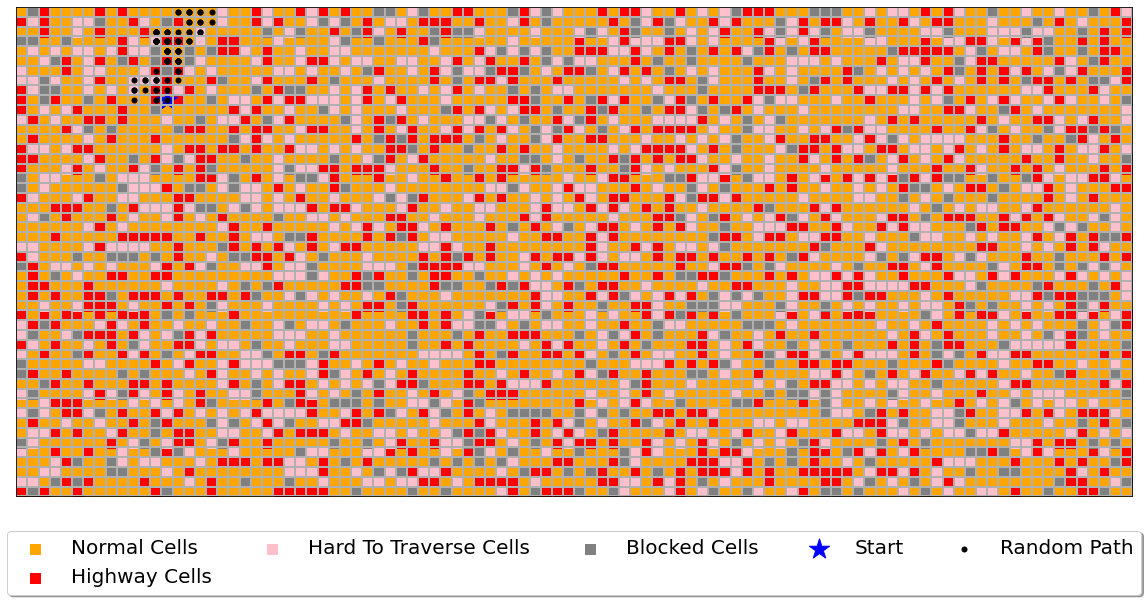

In [5]:
# generating a random grid w/starting point and the map
start, unknown_map = run_experiment()